# Electric Production

# DATA

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 9.8 MB 16.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joaoider","key":"c1a7e8f0581f6089f26e12b44828e32d"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!echo '{"username":"joaoider","key":"c1a7e8f0581f6089f26e12b44828e32d"}' > ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/ .kaggle/kaggle.json

chmod: cannot access '.kaggle/kaggle.json': No such file or directory


**LIBRARIES AND UTILITIES**

In [ ]:
import kaggle
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
from math import sqrt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from scipy.stats import boxcox

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor

In [ ]:
kaggle.api.authenticate()

**LOADING DATA**

In [ ]:
kaggle.api.dataset_download_files('shenba/time-series-datasets', path = './data', unzip = True)

In [ ]:
df = pd.read_csv('./data/Electric_Production.csv', index_col = 'DATE', parse_dates = True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.shape

(397, 1)

In [ ]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


**ROLLING STATISTICS**

The first thing to do in any data analysis task is to plot the data. Graphs enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relantioships between variables. The features that are seen in plots of the data must then be incorporated, as much as possible, into the forecasting methods to be used.

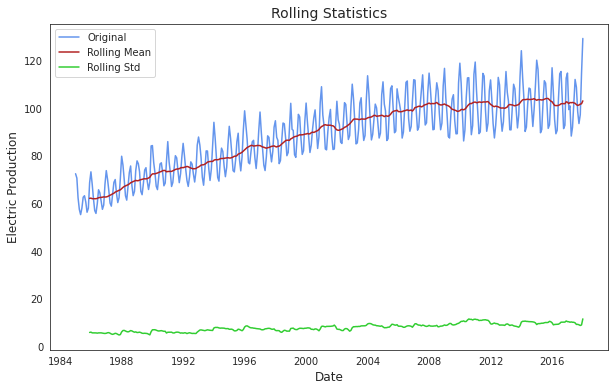

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.figure(figsize = (10, 6))
plt.plot(df, color = 'cornflowerblue', label = 'Original')
plt.plot(rolling_mean, color = 'firebrick', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'limegreen', label = 'Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

In [ ]:
df.columns = ['value']
df.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

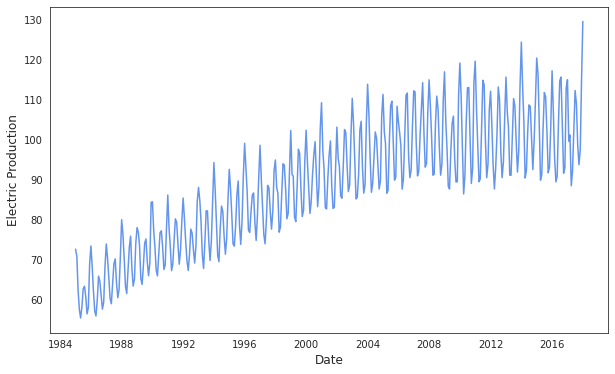

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an upward trend over the period of time.

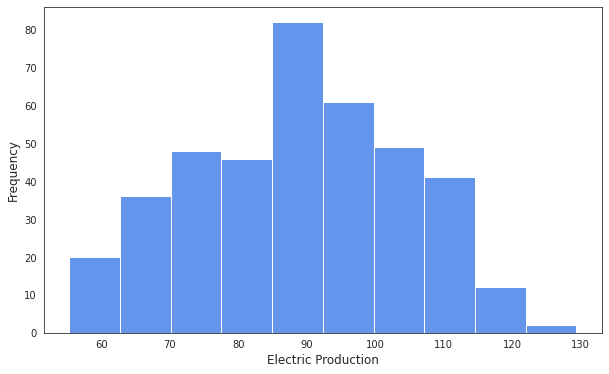

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [ ]:
print('Data Shape: {}'.format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


We will proceed by splitting the data into two parts so that we can then check the mean and variance of the data.

**MEAN OF DATA**

In [ ]:
print('Mean of value_1: {}'.format(round(value_1.mean()[0],3)))
print('Mean of value_2: {}'.format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


**VARIANCE OF DATA**

In [ ]:
print('Variance of value_1: {}'.format(round(value_1.var()[0],3)))
print('Variance of value_2: {}'.format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


**AUGUMENTED DICKEY-FULLER TEST** **bold text**

Augumented Dickey-Fuller Test is a common statistical test used to test whether a give time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn't depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

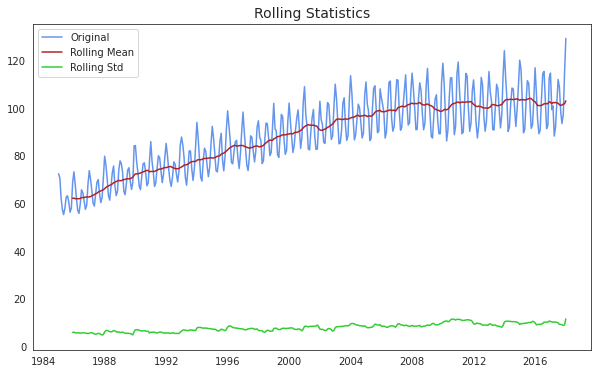

ADF Statistic: -2.257
p-value: 0.186
######################################
Critical Values
1%: -3.448
5%: -2.869
10%: -2.571
#################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [ ]:
def adfuller_test(ts, window = 12):
  
  movingAverage = ts.rolling(window).mean()
  movingSTD = ts.rolling(window).std()

  plt.figure(figsize = (10, 6))
  orig = plt.plot(ts, color= 'cornflowerblue', label = 'Original')
  mean = plt.plot(movingAverage, color ='firebrick', label = 'Rolling Mean')
  std = plt.plot(movingSTD, color = 'limegreen', label = 'Rolling Std')
  plt.legend(loc = 'upper left')
  plt.title('Rolling Statistics', size= 14)
  plt.show(block = False)

  adf = adfuller(ts, autolag = 'AIC')
  
  print('ADF Statistic: {}'.format(round(adf[0],3)))
  print('p-value: {}'.format(round(adf[1],3)))
  print('######################################')
  print('Critical Values')

  for key, ts in adf[4].items():
    print('{}: {}'.format(key, round(ts,3)))
  print('#################################')

  if adf[0] > adf[4]['5%']:
    print('ADF > Critical Values')
    print('Failed to reject null hypothesis, time series is non-stationary.')
  else:
    print('ADF < Critical Values')
    print('Reject null hypothesis, time series is stationary')

adfuller_test(df, window = 12)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of critical values.
Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

**CONVERTING DATA TO STATIONARY**

Logarithmic transformation with Box-Cox

The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as suite related transforms.

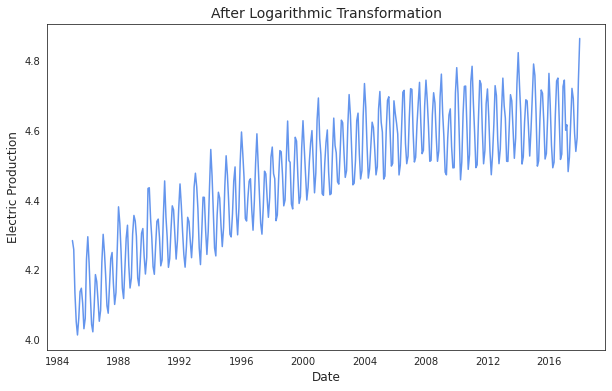

In [ ]:
df_log_scaled = df
df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda = 0.0)
plt.figure(figsize = (10, 6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title('After Logarithmic Transformation', size = 14)
plt.show()

**REMOVING TREND WITH MOVING AVERAGE**

A Time series with a trend is called non-stationary.
An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.
If a dataset does no have a trend ow we successfully remove the trend, the dataset is said to be trend stationary.

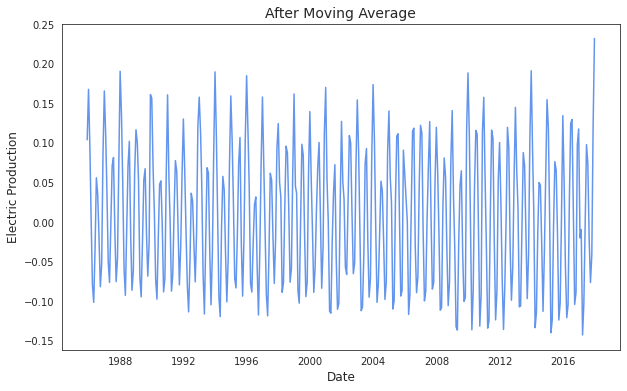

In [ ]:
moving_avg = df_log_scaled.rolling(window = 12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace = True)
plt.figure(figsize = (10, 6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title('After Moving Average', size =14)
plt.show()

**EXPONENTIAL DECAY TRANSFORMATION**

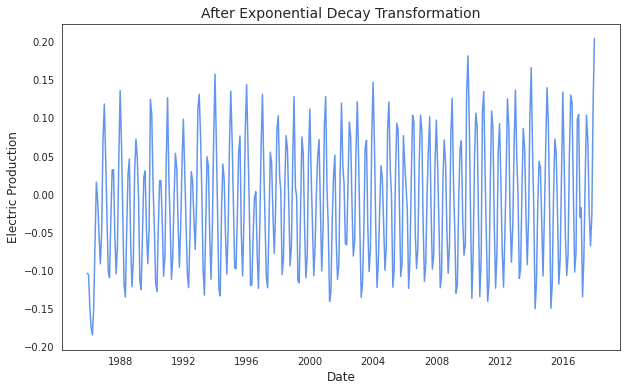

In [ ]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10, 6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title('After Exponential Decay Transformation', size= 14)
plt.show()

Let's test stationarity again

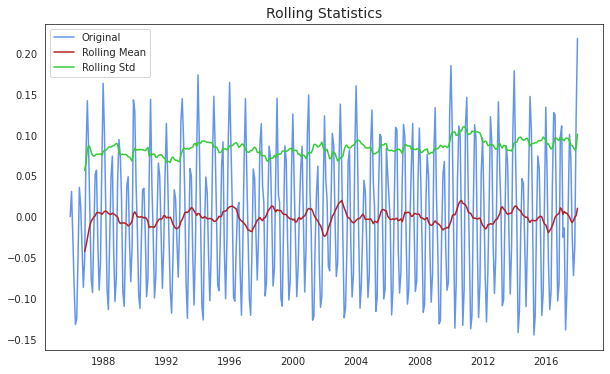

ADF Statistic: -7.213
p-value: 0.0
######################################
Critical Values
1%: -3.448
5%: -2.869
10%: -2.571
#################################
ADF < Critical Values
Reject null hypothesis, time series is stationary


In [ ]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that series is stationary.

In [ ]:
df_lsma_sub_df_lsma_ed

,value
DATE,
1985-12-01,0.000000
1986-01-01,0.030961
1986-02-01,-0.026624
1986-03-01,-0.083658
1986-04-01,-0.132042
...,...
2017-09-01,-0.022581
2017-10-01,-0.072251
2017-11-01,-0.035070


**DECOMPOSITION**

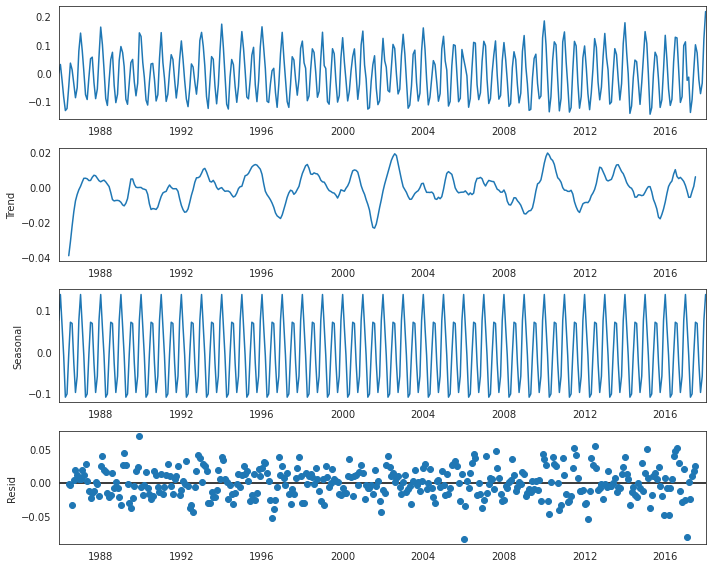

In [ ]:
rcParams['figure.figsize'] = 10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, model = 'duplicative')
df_seasonal_decompose.plot()
plt.show()

**ACF & PACF**

Autocorrelation and partial autorrelation plots are heavily used in time series analysis and forecasting.
Those are plot that graphically summarize the strength of a relantionship with an observation in a time series with observations at prior time steps.

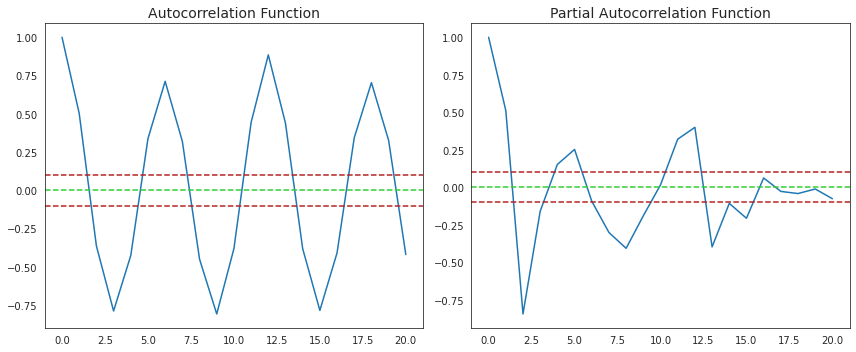

In [ ]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags = 20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags = 20, method = 'ols') 

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y = 0, linestyle = '--', color = 'limegreen')
plt.axhline(y = -1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)), linestyle = '--', color = 'firebrick')
plt.axhline(y = 1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)), linestyle = '--', color = 'firebrick')
plt.title('Autocorrelation Function', size = 14)

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y = 0, linestyle = '--', color = 'limegreen')
plt.axhline(y = -1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)), linestyle = '--', color = 'firebrick')
plt.axhline(y = 1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)), linestyle = '--', color = 'firebrick')
plt.title('Partial Autocorrelation Function', size = 14)

plt.tight_layout()

# Persistence Model

Let's say that we want to develop a model to predict the last 10 days of electric production in the dataset given all prior observations. The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with and autoregression model.

In [ ]:
df_lsma_sub_df_lsma_ed.head()

,value
DATE,
1985-12-01,0.000000
1986-01-01,0.030961
1986-02-01,-0.026624
1986-03-01,-0.083658
1986-04-01,-0.132042


In [ ]:
# df_lsma_sub_df_lsma_ed.values

In [ ]:
values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis = 1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values 

In [ ]:
train = per_values[1:len(per_values)-10]
test = per_values[len(per_values)-10:]
train, test

(array([[ 0.00000000e+00,  3.09610413e-02],
        [ 3.09610413e-02, -2.66237625e-02],
        [-2.66237625e-02, -8.36575872e-02],
        [-8.36575872e-02, -1.32041933e-01],
        [-1.32041933e-01, -1.24811999e-01],
        [-1.24811999e-01, -4.71343421e-02],
        [-4.71343421e-02,  3.57927327e-02],
        [ 3.57927327e-02,  1.24651451e-02],
        [ 1.24651451e-02, -3.80253070e-02],
        [-3.80253070e-02, -8.66067985e-02],
        [-8.66067985e-02, -5.10849436e-02],
        [-5.10849436e-02,  7.84725341e-02],
        [ 7.84725341e-02,  1.41975775e-01],
        [ 1.41975775e-01,  7.88331255e-02],
        [ 7.88331255e-02,  7.94713670e-03],
        [ 7.94713670e-03, -7.57726741e-02],
        [-7.57726741e-02, -9.29754237e-02],
        [-9.29754237e-02, -1.51552387e-02],
        [-1.51552387e-02,  5.14325430e-02],
        [ 5.14325430e-02,  5.68165771e-02],
        [ 5.68165771e-02, -3.32870508e-02],
        [-3.32870508e-02, -8.99192544e-02],
        [-8.99192544e-02, -5.572

In [ ]:
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
  return x

predictions = []
for i in X_test:
  y_pred = persistence(i)
  predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score, 4)))

Persistence MSE: 0.0084


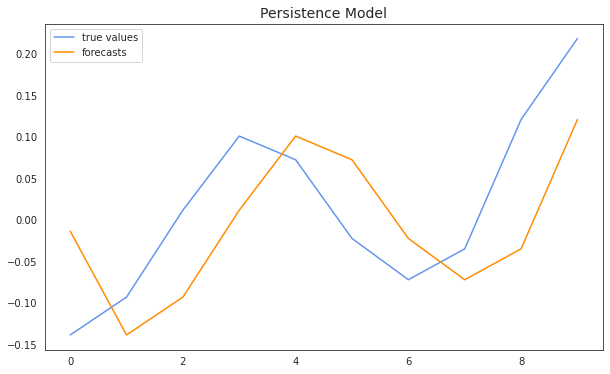

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(y_test, label = 'true values', color = 'cornflowerblue')
plt.plot(predictions, label = 'forecasts', color = 'darkorange')
plt.title('Persistence Model', size = 14)
plt.legend(loc = 'upper left')
plt.show()

# Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.
We could calculate the linear regression model manually using the LinearRegression class in scikit-learn and manually specify the lag input variables to use.
Alternately, the statsmodels library provides and autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

In [ ]:
ar_values = df_lsma_sub_df_lsma_ed.values

train = ar_values[1:len(ar_values)-10]
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order = (2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start = len(train), end = len(train)+len(test)-1, dynamic = False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score, 4)))

AR MSE: 0.0211


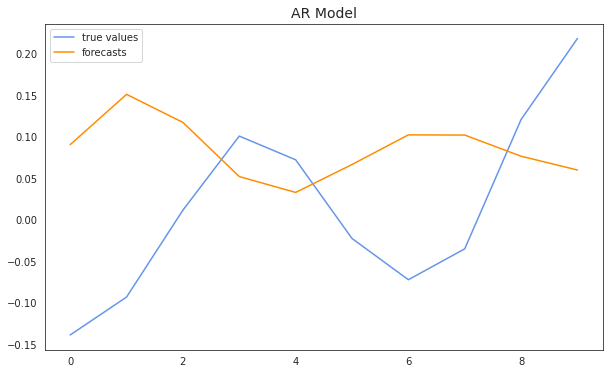

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(test, label = 'true values', color = 'cornflowerblue')
plt.plot(predictions, label = 'forecasts', color = 'darkorange')
plt.title('AR Model', size = 14)
plt.legend(loc = 'upper left')
plt.show()

# Moving Average Model

In [ ]:
model = ARIMA(train, order = (0,1,2))
MA_model = model.fit()
predictions = MA_model.predict(start = len(train), end=len(train)+len(test)-1, dynamic = False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score, 4)))

MA MSE: 0.0117


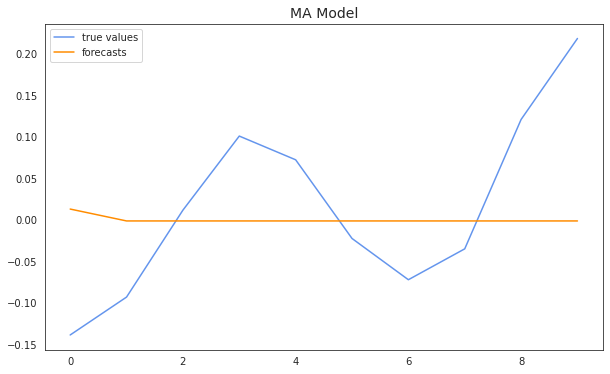

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(test, label = 'true values', color = 'cornflowerblue')
plt.plot(predictions, label = 'forecasts', color = 'darkorange')
plt.title('MA Model', size = 14)
plt.legend(loc = 'upper left')
plt.show()

# ARIMA

The statsmodels library provides the capability to fit an ARIMA model.
An ARIMA model can be created using the statsmodels library as follows:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let's start off with something simple. We will fit an ARIMA model to the entire Electric Production dataset.

In [ ]:
model = ARIMA(train, order = (2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start = len(train), end = len(train)+len(test)-1, dynamic = False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score, 4)))

ARIMA MSE: 0.0019


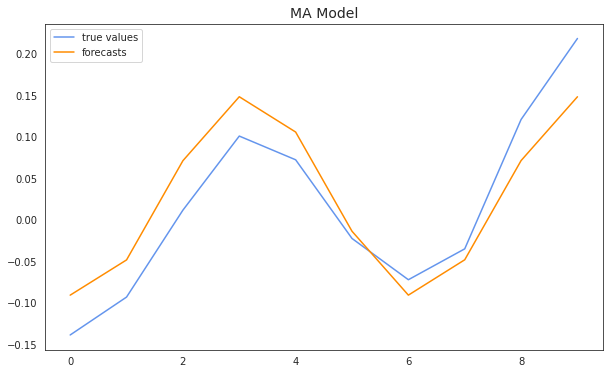

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(test, label = 'true values', color = 'cornflowerblue')
plt.plot(predictions, label = 'forecasts', color = 'darkorange')
plt.title('MA Model', size = 14)
plt.legend(loc = 'upper left')
plt.show()

# AUTOARIMA - SARIMAX

In [ ]:
fit_arima = auto_arima(df, d=1, start_p = 1, start_q = 1, max_p = 3, max_q = 3, seasonal = True, m = 6, D = 1, start_P = 1, start_Q = 1, max_P = 2, max_Q = 2, information_criterion = 'aic', trace = True, error_action = 'ignore', stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=-1646.682, Time=2.86 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=-1145.219, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=-1564.267, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=-1557.307, Time=3.24 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=-1632.894, Time=2.83 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=-1689.385, Time=5.06 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=-1632.583, Time=2.58 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=7.20 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=5.62 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=-1653.472, Time=3.29 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=-1636.483, Time=3.38 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=-1651.292, Time=3.62 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=i

In [ ]:
model = SARIMAX(df_lsma_sub_df_lsma_ed, order = (2, 1, 2), seasonal_order = (1, 1, 2, 6))
SARIMAX_model = model.fit()

predictions = SARIMAX_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic = False)
sarimax_score = mean_squared_error(test, predictions)
print('SARIMAX MSE: {}'.format(round(sarimax_score, 4)))

SARIMAX MSE: 0.0097


In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(test, label = 'true values', color = 'cornflowerblue')
plt.plot(predictions, label = 'forecasts', color = 'darkorange')
plt.title('MA Model', size = 14)
plt.legend(loc = 'upper left')
plt.show()

ValueError: ignored

<Figure size 720x432 with 1 Axes>

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  386
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                 880.554
Date:                           Tue, 10 May 2022   AIC                          -1745.109
Time:                                   14:43:58   BIC                          -1713.609
Sample:                               12-01-1985   HQIC                         -1732.608
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4300      0.057     -7.544      0.000      -0.542      -0.318
ar.L2          0.5609      0.051     11.067      0.000       0.462       0.660
ma.L1         -0.0355      0.303     -0.117      0.907      -0.630       0.559
ma.L2         -0.9630      0.294     -3.276      0.001      -1.539      -0.387
ar.S.L6       -0.9947      0.005   -205.265      0.000      -1.004      -0.985
ma.S.L6       -0.0603      4.930     -0.012      0.990      -9.723       9.602
ma.S.L12      -0.9396      4.645     -0.202      0.840     -10.044       8.165
sigma2         0.0005      0.003      0.202      0.840      -0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.24   Prob(JB):                         0.15
Heteroskedasticity (H):               1.48   Skew:                             0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predicoes = SARIMAX_model.get_prediction(start = -12)
predicao_media = predicoes.predicted_mean

In [ ]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(0.002807638809289102, 0.09216338715427233)

In [ ]:
predicao_media[0]

0.04748551298178072

In [ ]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df_lsma_sub_df_lsma_ed.index)

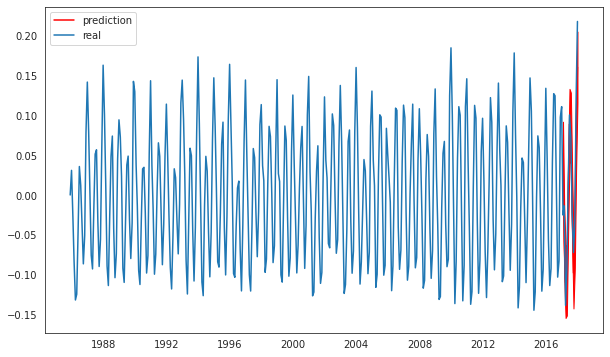

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(datas_previsao, predicao_media.values, color = 'red', label = 'prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color = 'red')
plt.plot(datas, df_lsma_sub_df_lsma_ed.values, label = 'real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

rmse_sarima = sqrt(mean_squared_error(df_lsma_sub_df_lsma_ed[-12:].values, predicao_media.values))
print(rmse_sarima)

0.03510029432650245


Forecast com ARIMA

In [ ]:
# Forecast para 12 values

forecast = SARIMAX_model.get_forecast(steps = 12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [ ]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[0], intervalo_acima_f[0]

(0.055431168032053335, 0.14475621540021744)

In [ ]:
forecast_medio[0]

0.10009369171613539

In [ ]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates = np.asarray(predicao_media.index)

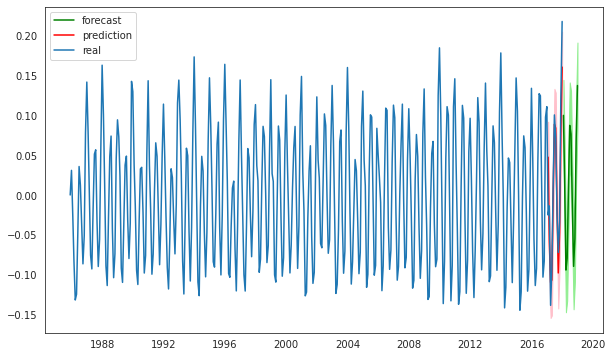

In [ ]:
dates = np.asarray(df_lsma_sub_df_lsma_ed.index)
plt.figure(figsize = (10, 6))
plt.plot(datas_forecast, forecast_medio.values, color = 'green', label = 'forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color = 'lightgreen')

plt.plot(datas_previsao, predicao_media.values, color = 'red', label = 'prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color = 'pink')
plt.plot(dates, df_lsma_sub_df_lsma_ed.values, label = 'real')
plt.legend(loc = 'upper left')
plt.show()

# XGBOOST

In [ ]:
df = pd.read_csv('./data/Electric_Production.csv', index_col = 'DATE', parse_dates = True)
df.columns = ['value']
df.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
#xgb_values = df.values

#train = xgb_values[1:len(xgb_values)-15]
#test = xgb_values[len(xgb_values)-15:]

#train.shape, test.shape

In [ ]:
treino = df.loc[df.index <= '2016-12-31']
len(treino)

384

In [ ]:
validacao = df.loc[df.index > '2016-12-31']
len(validacao)

13

In [ ]:
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [ ]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

Criando a variável target e a lagged variable(que já é a consumo)

In [ ]:
treino['value']

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2016-08-01    115.5159
2016-09-01    102.7637
2016-10-01     91.4867
2016-11-01     92.8900
2016-12-01    112.7694
Name: value, Length: 384, dtype: float64

In [ ]:
treino['value'].shift(-1)

DATE
1985-01-01     70.6720
1985-02-01     62.4502
1985-03-01     57.4714
1985-04-01     55.3151
1985-05-01     58.0904
                ...   
2016-08-01    102.7637
2016-09-01     91.4867
2016-10-01     92.8900
2016-11-01    112.7694
2016-12-01         NaN
Name: value, Length: 384, dtype: float64

In [ ]:
treino['target'] = treino['value'].shift(-1)
treino.head()

,value,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [ ]:
treino.tail()

,value,target
DATE,,
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694
2016-12-01,112.7694,NaN


In [ ]:
treino = treino.dropna()
treino.tail()

,value,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [ ]:
validacao['target'] = validacao['value'].shift(-1)
validacao.head()

,value,target
DATE,,
2017-01-01,114.8505,99.4901
2017-02-01,99.4901,101.0396
2017-03-01,101.0396,88.3530
2017-04-01,88.3530,92.0805
2017-05-01,92.0805,102.1532


In [ ]:
validacao.tail()

,value,target
DATE,,
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048
2018-01-01,129.4048,NaN


In [ ]:
validacao = validacao.dropna()
validacao.tail()

,value,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048


In [ ]:
X_treino = treino.loc[:, ['value']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['value']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (12, 1), (12, 1))

In [ ]:
modelo_xgb_um_mes = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000)
XGB_model = modelo_xgb_um_mes.fit(X_treino, y_treino)

In [ ]:
#predictions = XGB_model.predict(start = len(treino), end=len(treino)+len(validacao)-1, dynamic = False)
#xgb_score = mean_squared_error(treino, predictions)
#print('XGB MSE: {}'.format(round(xgb_score, 4)))

In [ ]:
ultima_linha = treino.iloc[-1]
ultima_linha['value']

92.89

In [ ]:
ultimo_valor_treino = np.array([ultima_linha['value']])
ultimo_valor_treino

array([92.89])

In [ ]:
predicao = modelo_xgb_um_mes.predict(ultima_linha['value'])
predicao

array([108.26969], dtype=float32)

In [ ]:
X_validacao[0]

array([114.8505])

In [ ]:
xgb_score = mean_squared_error(X_validacao[0], predicao)

# Mean Squared Errors

In [ ]:
errors = pd.DataFrame()
errors['Model'] = ['Persistence', 'Autoregression', 'Moving Average', 'ARIMA', 'SARIMAX', 'XGBoost']
errors['MSE'] = [persistence_score, ar_score, ma_score, arima_score, sarimax_score, xgb_score]
errors = errors.sort_values('MSE', ascending = True, ignore_index = True)
errors.index = errors.Model
del errors['Model']

def coloring_bg(s, min_, max_, cmap = 'Reds', low = 0, high = 0):
  color_range = max_ - min_
  norm = colors.Normalize(min_ - (color_range*low), max_ + (color_range*high))
  normed = norm(s.values)
  c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
  return['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg, min_ = errors.min().min(), max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
ARIMA,0.001916
Persistence,0.008401
SARIMAX,0.009750
Moving Average,0.011716
Autoregression,0.021126
XGBoost,43.307041
